In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go
import cache_magic

from tracking_v2.target.autopilot import Straight, Turn, _populate_coordinates, _plot_path, AutopilotTarget
from tracking_v2.kalman import LinearKalmanFilter
from tracking_v2.motion import ConstantVelocityModel, ConstantAccelerationModel
from tracking_v2.sensor import GeometricSensor
from tracking_v2.evaluation import FilterRunner, evaluate_nees, evaluate_runner, plot_nscore, plot_2d, evaluate_error, plot_error_vs_nees

from tracking_v2.util import to_df, display

In [4]:
display.as_png = True

In [5]:
def _plot_error_many(runner, skip=100):
    tm  = np.arange(runner.n-skip)
    err = np.linalg.norm(runner.many_x_hat[:,skip:,:3,0] - runner.many_truth[:,(skip+1):,:3], axis=2)
    
    avg = np.array((tm, err.mean(axis=0))).T
    avg = to_df(avg, columns=['time', 'err'])
    avg['type'] = 'avg'
    
    low = np.array((tm, np.quantile(err, .025, axis=0))).T
    low = to_df(low, columns=['time', 'err'])
    low['type'] = '.025'
    
    upp = np.array((tm, np.quantile(err, .975, axis=0))).T
    upp = to_df(upp, columns=['time', 'err'])
    upp['type'] = '.975'

    err = pd.concat((avg, low, upp), axis=0).melt(['time', 'type'], ['err'], 'dim', 'error')
    return display(ex.line(err, x='time', y='error', color='type', facet_row='dim'))

def _plot_nees(runner, skip=100):
    nees = evaluate_nees(runner.many_x_hat[:, :, :3, :], runner.many_P_hat[:, :, :3, :3], runner.many_truth[:, 1:, :3])
    err = np.asarray((np.arange(runner.n-skip), nees.scores[:,skip:].mean(axis=0))).T
    err = to_df(err, columns=['time', 'nees'])
    fig = ex.line(err, x='time', y='nees')

    ci = sp.stats.chi2.ppf([0.025, 0.975], runner.m * nees.dim) / runner.m
    fig.add_hline(y=ci[0], line_width=.5, line_dash="dash", line_color="red")
    fig.add_hline(y=ci[1], line_width=.5, line_dash="dash", line_color="red")
    
    fig.add_trace(go.Scatter(x=[0], y=[0], mode='lines', line=dict(color="red", dash="dash"), name='2.5% CI',
        showlegend=True, visible='legendonly'))

    return display(fig)

# Autopilot configuration

In [6]:
thrust = 80
drag_coeff = .05
max_turn_rate = 5

v_max = np.sqrt(2 * thrust / drag_coeff)
R_min = v_max / (max_turn_rate / 180 * np.pi)
v_max, R_min

(56.568542494923804, 648.2277476331165)

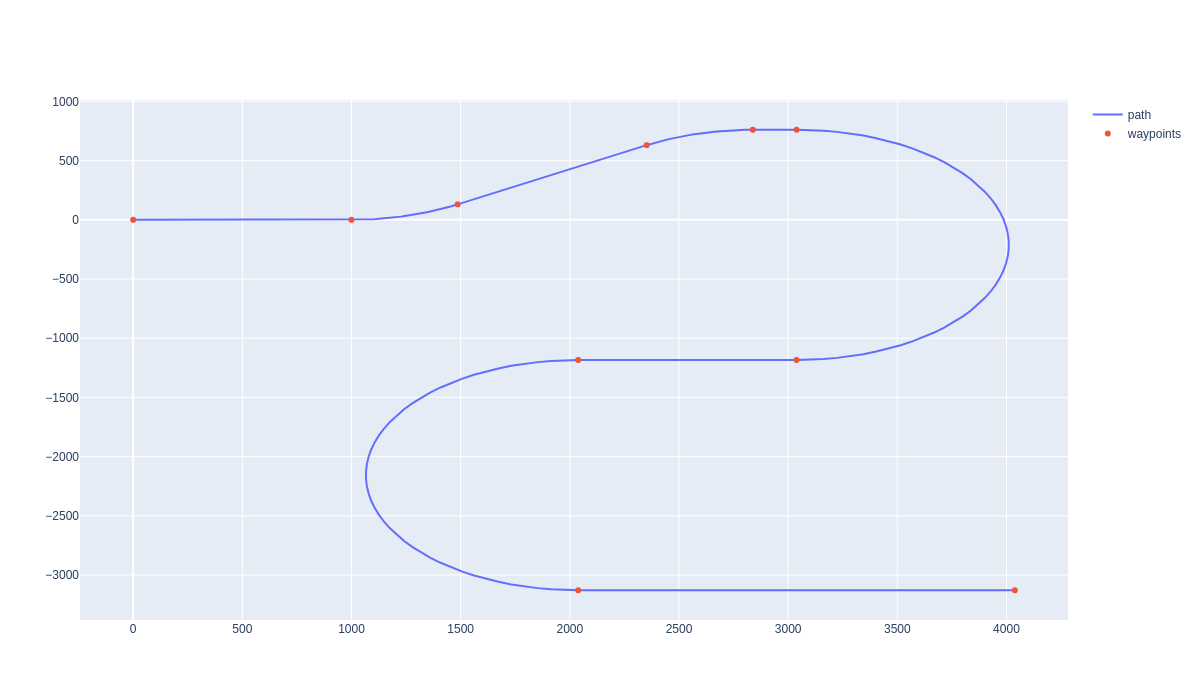

In [7]:
turn_radius = R_min * 1.5
commands = [Straight(1000), Turn(turn_radius, 30), Straight(1000), Turn(turn_radius, 30, left=False), Straight(200),
            Turn(turn_radius, 180, False), Straight(1000), Turn(turn_radius, 180, True), Straight(2000)]
_populate_coordinates([0,0,0], 0, commands)
display(_plot_path(commands))

In [8]:
target = AutopilotTarget(commands, integration_steps_count=20, thrust_N=thrust, drag_coefficient=drag_coeff,
                         max_turn_rate_deg_s=max_turn_rate, noise_intensity=150)

## Mover path divergence

Autopilot Target uses the `ForceWaypointMover` to simulate process noise due to external forces. In effect, the generated path oscillates around the path requested by the user. The amplitude of these oscillations is controlled by the `noise_intensity` argument while their specific shape results from external forces generated randomly in each integration step.

Below, we plot the error between the requested path and the actual mover position, in each time step, separately in each dimension.

end of the line


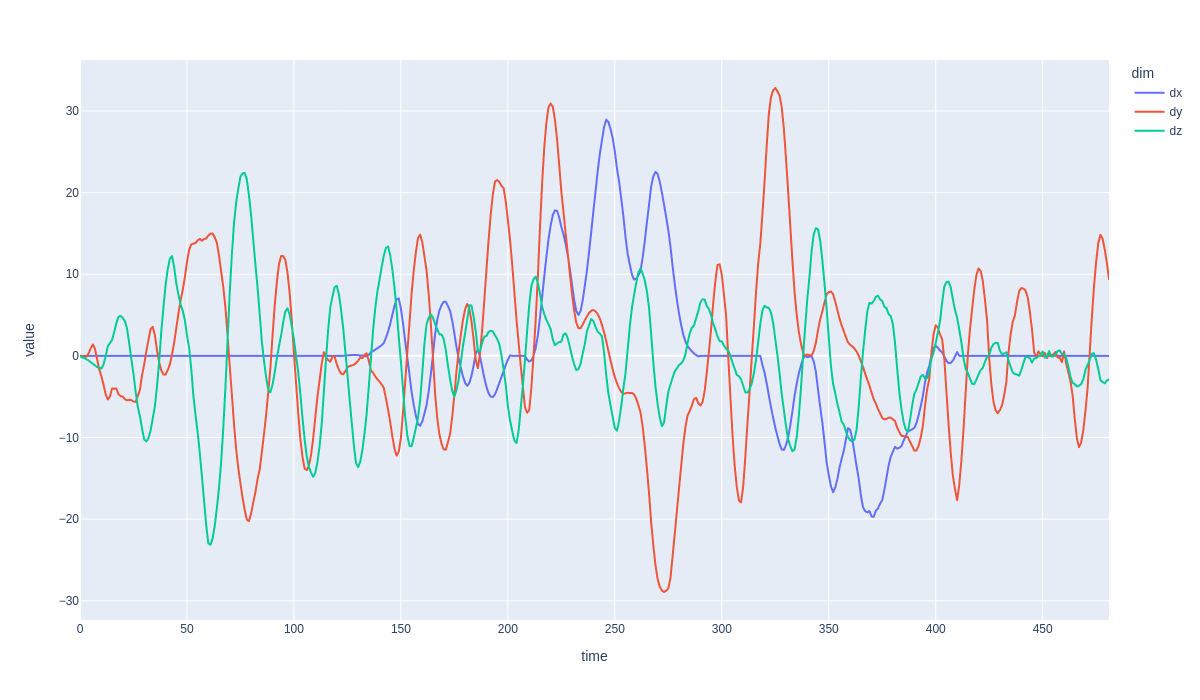

In [9]:
s = target.true_states(n=1200, debug=True)

fig = ex.line(s.melt(['time'], ['dx', 'dy', 'dz'], 'dim', 'value'), x='time', y='value', color='dim')
display(fig)

## Movement along the path

Below, we plot the actual mover path overlaid with the path requested by the user.

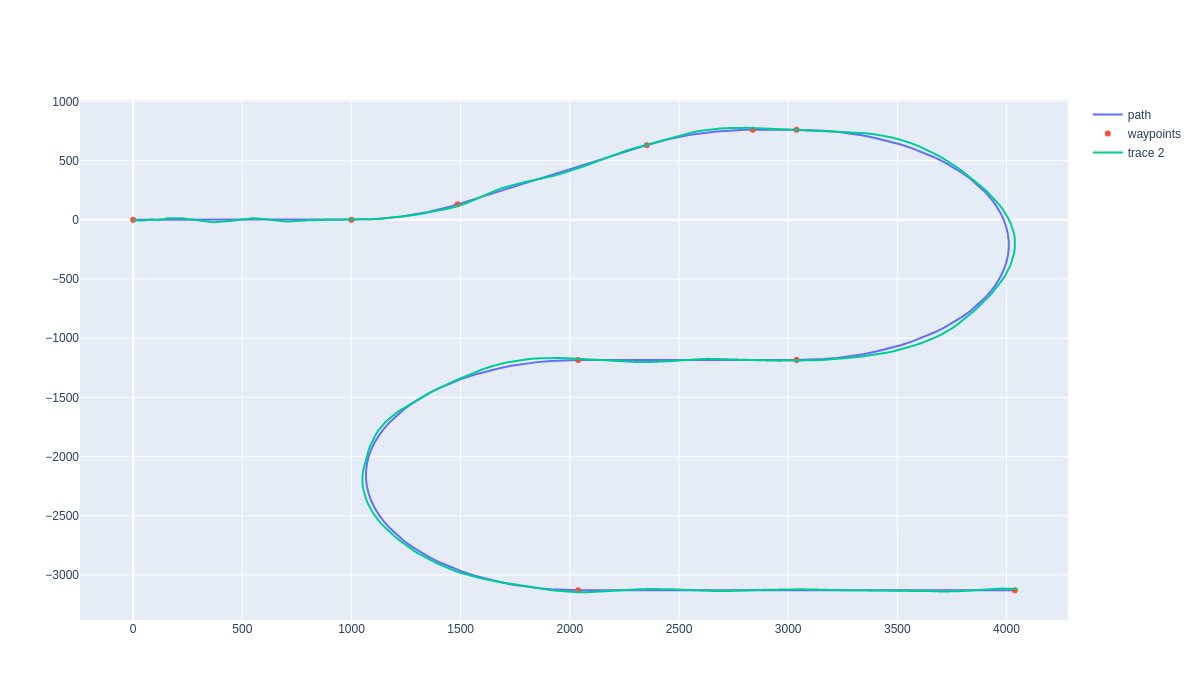

In [10]:
fig = _plot_path(commands)
fig.add_trace(go.Scatter(x=s['mx'], y=s['my'], mode='lines'))
display(fig)

# Autopilot Target and Kalman Filter

Now we attempt to filter measurements of the measured position of the Autopilot Target, subject to measurement noise. The goal of this exercise is to determine the statistical match between process noise produced by the Autopilot Target and the Constant Acceleration Motion Model.

The Autopilot Target implements process noise through external forces applied randomly, combined with Autopilot logic which recalculates the direction of movement in each iteration such that it follows the requested path, subject to turn rate limit.

In [11]:
def _create_ca(noise_intensity):
    ca = LinearKalmanFilter(ConstantAccelerationModel(noise_intensity=noise_intensity),
                        [[1, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0, 0, 0, 0]])
    return ca

In [12]:
sensor = GeometricSensor(seed=0)

runner = FilterRunner(target, sensor, _create_ca(.2))
runner.run_many(1, 500)

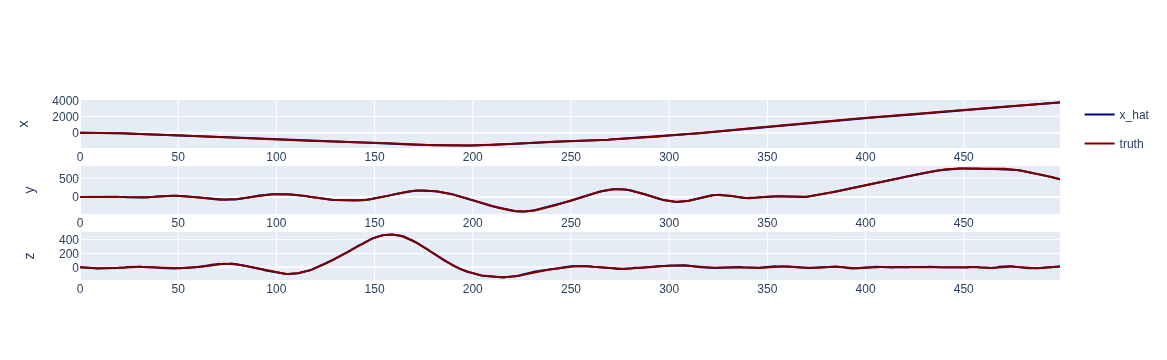

In [13]:
plot_2d(runner)

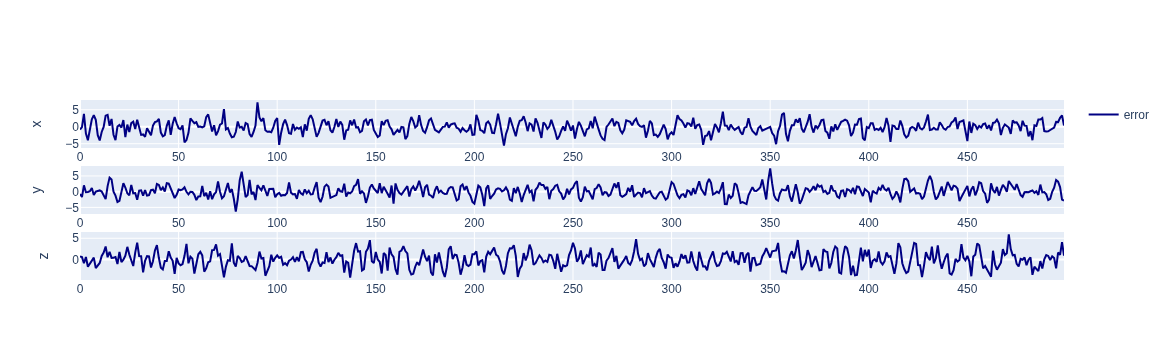

In [14]:
plot_2d(runner, residual=True)

NEES resulting from CA motion model applied to an Autopilot Target seems statistically consistent with the two-sided 5% confidence interval for the Chi-squared distribution.

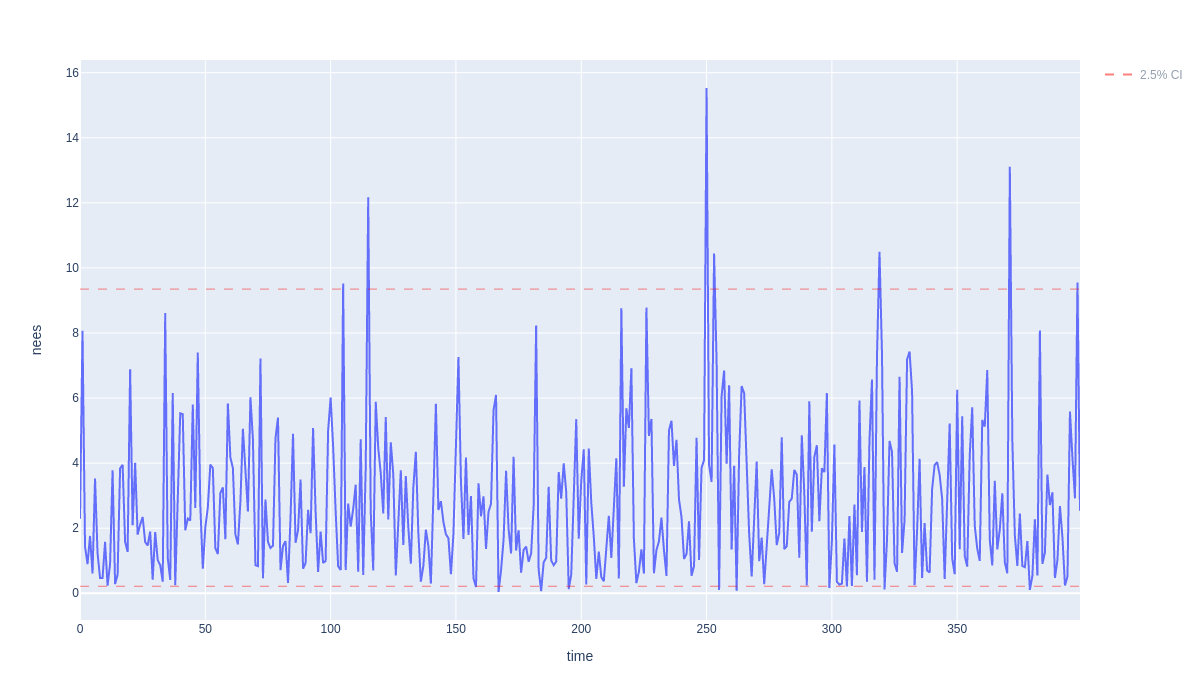

In [15]:
_plot_nees(runner)

In [16]:
runner.run_many(m=100, n=400)

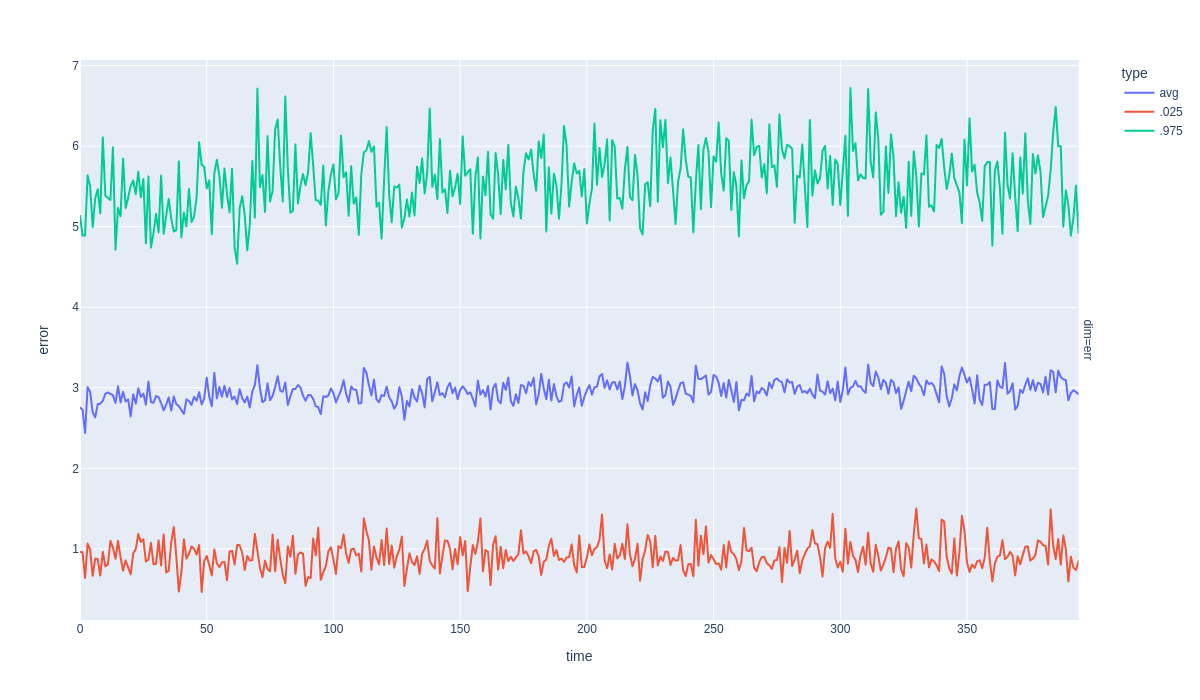

In [17]:
_plot_error_many(runner, skip=5)

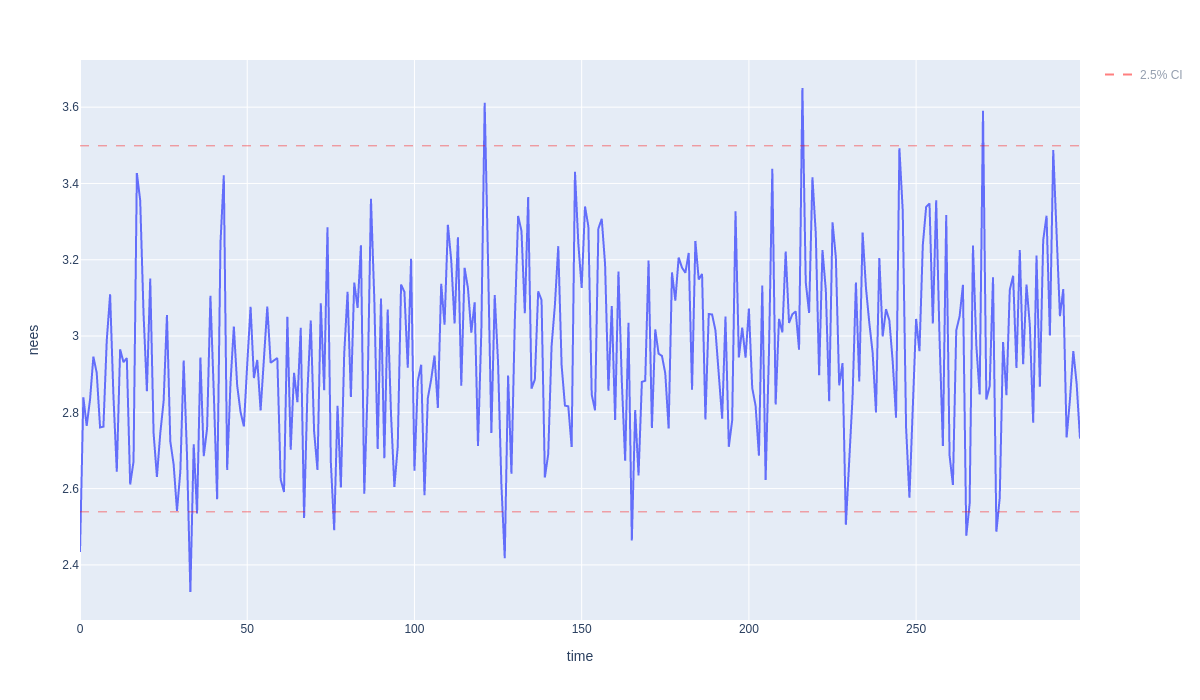

In [18]:
_plot_nees(runner)

In [19]:
e = evaluate_runner(runner)

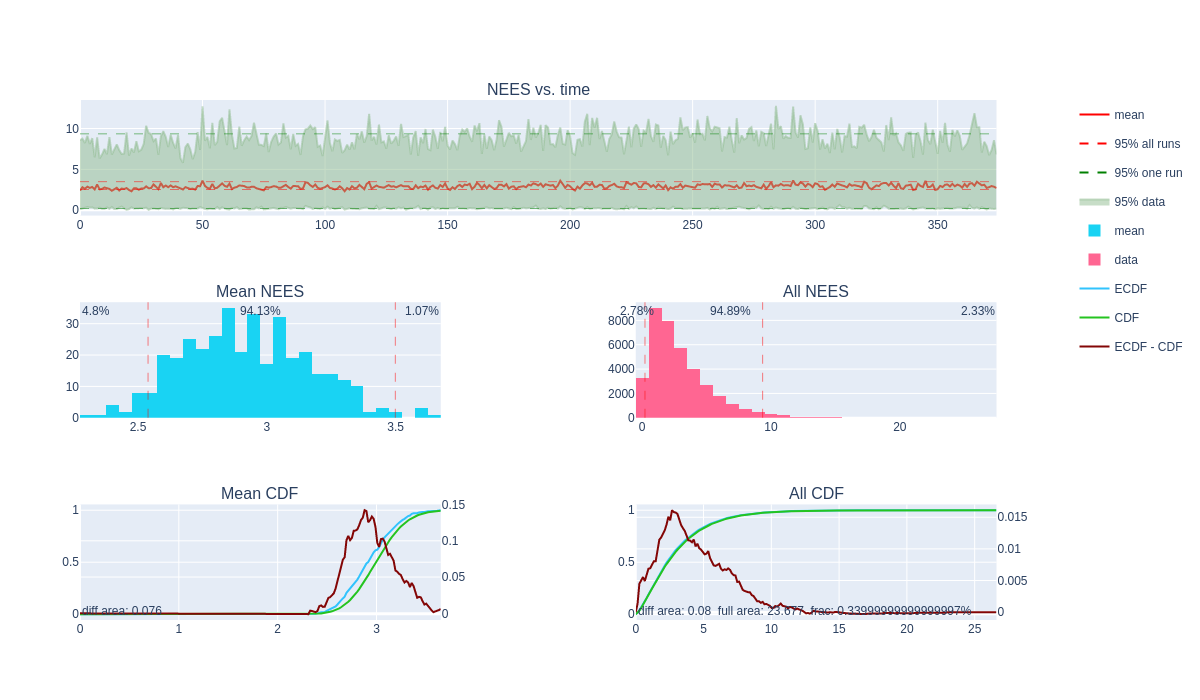

In [20]:
plot_nscore(e.position_nees)

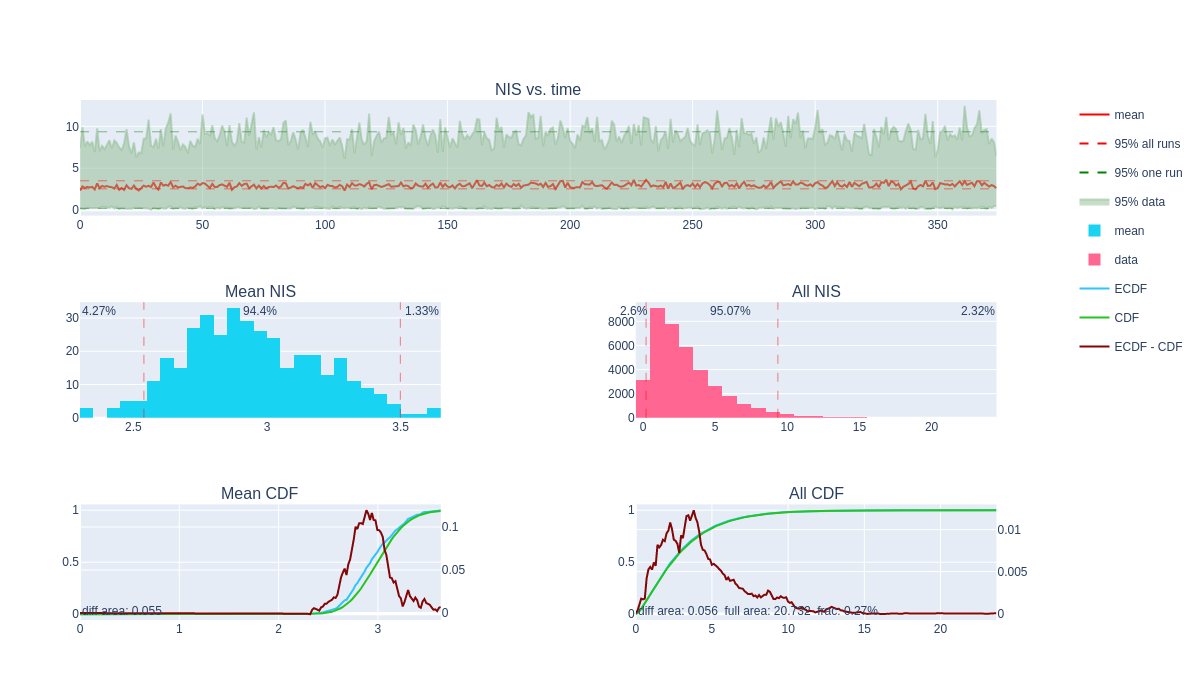

In [21]:
plot_nscore(e.position_nis)

# Compare impact of noise Q

Compare the NEES and true error across a number of noise intensity settings for the Constant Acceleration motion model.

In [22]:
def _generate():
    sensor = GeometricSensor(seed=0)

    runners, tags = [], []
    for Q in [0.005, .01, .05, .1, .2, .5, 1, 2, 5]:
        r = FilterRunner(target, sensor, _create_ca(Q))
        r.run_many(100, 400)

        runners.append(r)
        tags.append(dict(Q=str(Q)))
    
    return runners, tags

%cache runners_and_tags = _generate()
runners, tags = runners_and_tags

Loading cached value for variable 'runners_and_tags'. Time since caching: 0:00:44.410062


We observe the best match for `Q = .2`

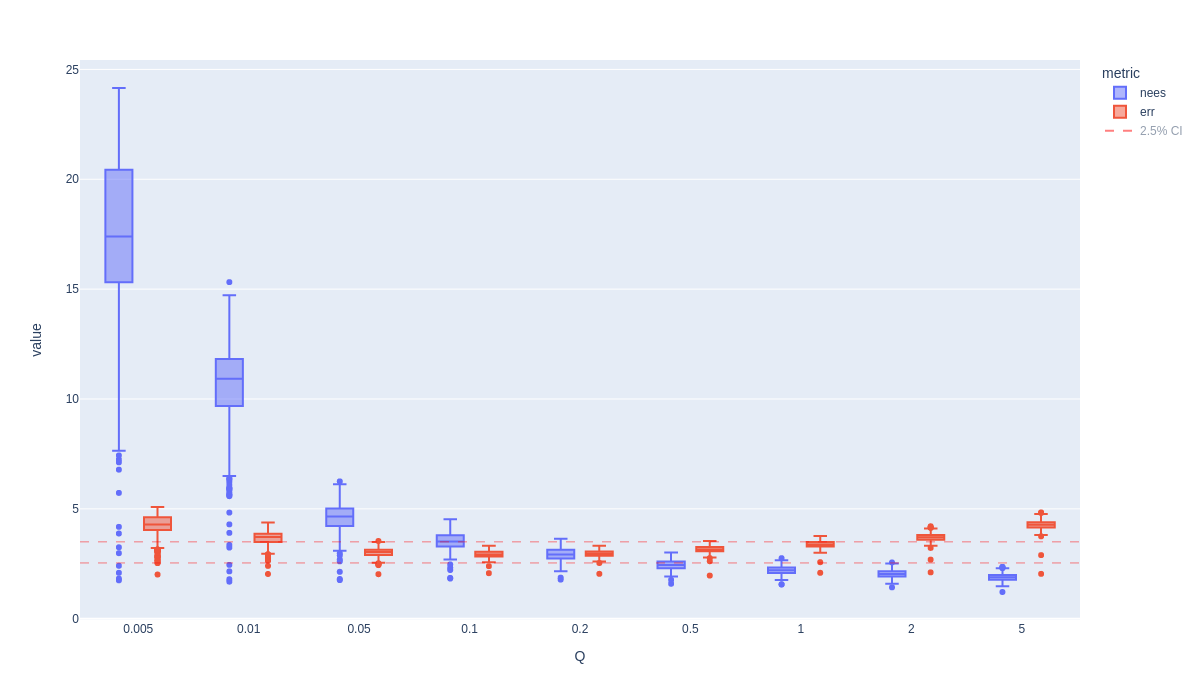

In [23]:
plot_error_vs_nees(runners, tags, x='Q')